## This notebook tests a different network design from the [proposed one](TR-GY7133_AS4.ipynb).

# 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sympy as sp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set parameters
v_walk = 3 # walk speed (mph)
v_bus = 10 # bus speed (mph)
alpha = 0.5 # headway reliability
beta = -7 # elasticity
threshold = 0.5 # acceptable access distance (mile)
budget = 10 # operation budget (veh * hr)
freq_min = 1 # minimum freq for each zone (veh / hr)

# 1. Stops Allocation and Route Determination

In [3]:
# read data
df = pd.read_csv("ODpair.csv", index_col=0)
df

,O-x,O-y,D-x,D-y,K
1,3.990,1.978,4.848,2.582,500
2,0.624,3.954,3.706,3.508,500
3,2.841,0.927,4.776,4.150,500
4,0.452,2.411,4.963,3.474,500
5,1.262,2.485,0.659,0.962,500
6,0.564,4.598,4.409,4.956,250
7,0.697,3.301,2.362,1.704,250
8,1.502,4.521,0.972,0.117,250
9,0.173,3.789,3.827,2.882,250
10,4.728,4.073,2.238,0.374,250


In [4]:
# generate separate dfs for Origin and Destination zones
O = df[['O-x', 'O-y', 'K']]
D = df[['D-x', 'D-y', 'K']]

/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/text.py:2108: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


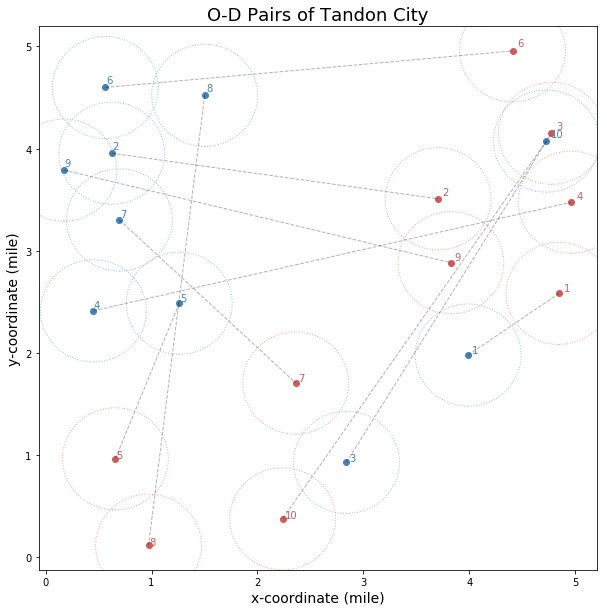

In [5]:
# plot all zones, O-D pairs, and accessible range
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(df['O-x'], df['O-y'], 'o', color='steelblue')
ax.plot(df['D-x'], df['D-y'], 'o', color='indianred')

for i in range(1,len(df)+1):
    access_O = plt.Circle((df['O-x'][i], df['O-y'][i]), threshold, ls=':', color='steelblue', fill=False, alpha=0.5)
    access_D = plt.Circle((df['D-x'][i], df['D-y'][i]), threshold, ls=':', color='indianred', fill=False, alpha=0.5)
    ax.annotate(i, [df['O-x'][i], df['O-y'][i]], textcoords='offset points', color='steelblue')
    ax.annotate(i, [df['D-x'][i], df['D-y'][i]], textcoords='offset points', color='indianred')
    ax.plot([df['O-x'][i], df['D-x'][i]], [df['O-y'][i], df['D-y'][i]], 'k--', linewidth=1, alpha=0.3)
    ax.add_artist(access_O)
    ax.add_artist(access_D)

plt.xlabel('x-coordinate (mile)', fontsize=14)
plt.ylabel('y-coordinate (mile)', fontsize=14)
plt.title('O-D Pairs of Tandon City', fontsize=18)

plt.show()

In [6]:
# define tool functions
def midpoint(points):
    """
    Calculate the midpoint of a list of points,
    or return the coordinate of a single point.
    """
    coords = []
    for p in points:
        if p[0] == 'O':
            coords.append(O.iloc[int(p[1:])-1,:2])
        else:
            coords.append(D.iloc[int(p[1:])-1,:2])
    return np.array(coords).mean(axis=0)

def nearest(points):
    """
    Find the nearest point on a circle to a line.
    INPUT three points as a list:
    - the first two determine the line function
    - the third determines the circle with r = threshold
    """
    coords = np.array(points)
    xc = coords[2][0] # centroid x-coord of circle
    yc = coords[2][1] # centroid y-coord of circle

    diff = coords[1] - coords[0]
    a = - diff[0] / diff[1] # slope of the perpendicular line function
    b = yc - a * xc     # intercept of the perpendicular line function

    # solve equation (two solutions: farest and nearest)
    x = sp.symbols('x')
    sol_x = sp.solve((x - xc) ** 2 + (a * x + b - yc) ** 2 - threshold ** 2, x)
    
    y0 = a * sol_x[0] + b # solution coordinate 1
    y1 = a * sol_x[1] + b # solution coordinate 2
    
    # determine which of the two solutions is the nearer one
    dist0 = (sol_x[0] - coords[0][0]) ** 2 + (y0 - coords[0][1]) ** 2
    dist1 = (sol_x[1] - coords[0][0]) ** 2 + (y1 - coords[0][1]) ** 2
    
    if dist0 < dist1:
        return numpy.float64([sol_x[0], y0])
    else:
        return numpy.float64([sol_x[1], y1])

In [7]:
# determine stops covering several zones
stop1 = midpoint(['O8'])
stop2 = midpoint(['O6'])
stop3 = midpoint(['O2'])
stop4 = midpoint(['O7'])
stop5 = midpoint(['O4', 'O5'])
stop6 = midpoint(['D5'])
stop7 = midpoint(['D8'])
stop8 = midpoint(['D10'])
stop9 = midpoint(['O3', 'D7'])
stop10 = midpoint(['O1', 'D9'])
stop11 = midpoint(['D1', 'D4'])
stop12 = midpoint(['D2'])
stop13 = midpoint(['O10'])
stop14 = midpoint(['D3'])
stop15 = midpoint(['D6'])

# determine detours of the skeletal route
# in order to cover a single zone
# stop5 = nearest([stop4, stop6, midpoint(['D10'])])
# stop9 = nearest([stop8, stop10, midpoint(['D2'])])

# generate list of stops
stops = np.array([stop1, stop2, stop3, stop4, stop5, stop6, stop7, stop8, stop9, stop10,
                  stop11, stop12, stop13, stop14, stop15, stop1]).T
stops

array([[1.502 , 0.564 , 0.624 , 0.697 , 0.857 , 0.659 , 0.972 , 2.238 ,
        2.6015, 3.9085, 4.9055, 3.706 , 4.728 , 4.776 , 4.409 , 1.502 ],
       [4.521 , 4.598 , 3.954 , 3.301 , 2.448 , 0.962 , 0.117 , 0.374 ,
        1.3155, 2.43  , 3.028 , 3.508 , 4.073 , 4.15  , 4.956 , 4.521 ]])

## >>> CHECKPOINT 1: Stops Generation
To test different output, modify stops here!

In [8]:
[print(i) for i in range(len(stops))]

0
1


[None, None]

/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/text.py:2108: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


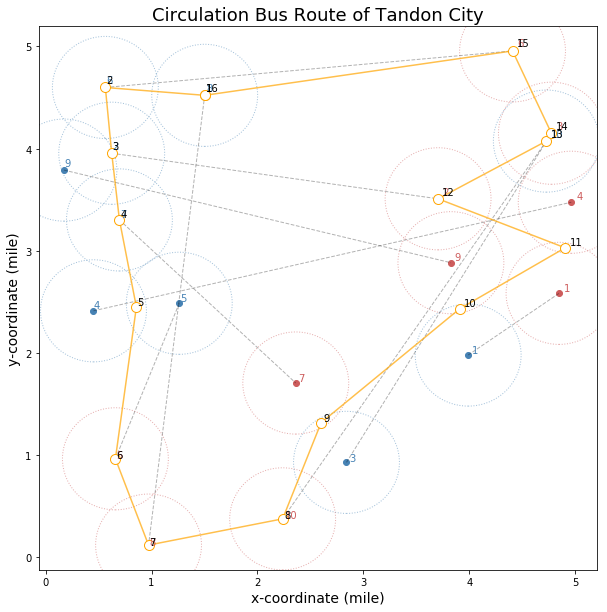

In [9]:
# plot proposed route and stops
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(df['O-x'], df['O-y'], 'o', color='steelblue')
ax.plot(df['D-x'], df['D-y'], 'o', color='indianred')

for i in range(1,len(df)+1):
    access_O = plt.Circle((df['O-x'][i], df['O-y'][i]), threshold, ls=':', color='steelblue', fill=False, alpha=0.5)
    access_D = plt.Circle((df['D-x'][i], df['D-y'][i]), threshold, ls=':', color='indianred', fill=False, alpha=0.5)
    ax.annotate(i, [df['O-x'][i], df['O-y'][i]], textcoords='offset points', color='steelblue')
    ax.annotate(i, [df['D-x'][i], df['D-y'][i]], textcoords='offset points', color='indianred')
    ax.plot([df['O-x'][i], df['D-x'][i]], [df['O-y'][i], df['D-y'][i]], 'k--', linewidth=1, alpha=0.3)
    ax.add_artist(access_O)
    ax.add_artist(access_D)

ax.plot(stops[0], stops[1], '-', color='orange', alpha=0.7)
ax.plot(stops[0], stops[1], 'o', markerfacecolor='white', markeredgecolor='orange', markersize=10)
[ax.annotate(i+1, [stops[0][i], stops[1][i]], textcoords='offset points') for i in range(len(stops[0]))]

plt.xlabel('x-coordinate (mile)', fontsize=14)
plt.ylabel('y-coordinate (mile)', fontsize=14)
plt.title('Circulation Bus Route of Tandon City', fontsize=18)

# plt.savefig('fig1.png', dpi=300)
plt.show()

# 2. Cost and Demand Calculations

In [10]:
# generate a df of stops
stops_df = pd.DataFrame(stops.T)
stops_df.columns = ['x', 'y']

In [11]:
# generate a df of coordinate differences
diff_df = stops_df.diff()
diff_df.drop(0, axis=0, inplace=True)
diff_df.columns = ['dx', 'dy']

# calculate segment lengths
diff_df['diff'] = np.sqrt(diff_df['dx']**2 + diff_df['dy']**2)
RT_length = diff_df['diff'].sum()
print("Total Route Length: ", RT_length, " miles")

# calculate distance along route for both directions
diff_df['dist_ACW'] = diff_df['diff'].cumsum()
diff_df['dist_CW'] = list(reversed(list(diff_df['dist_ACW'])))
diff_df

Total Route Length:  17.06991329060553  miles


,dx,dy,diff,dist_ACW,dist_CW
1,-0.9380,0.0770,0.941155,0.941155,17.069913
2,0.0600,-0.6440,0.646789,1.587944,14.130547
3,0.0730,-0.6530,0.657068,2.245012,13.244926
4,0.1600,-0.8530,0.867876,3.112888,13.154190
5,-0.1980,-1.4860,1.499133,4.612021,11.986410
6,0.3130,-0.8450,0.901107,5.513128,10.694435
7,1.2660,0.2570,1.291822,6.804951,9.531846
8,0.3635,0.9415,1.009235,7.814185,7.814185
9,1.3070,1.1145,1.717661,9.531846,6.804951
10,0.9970,0.5980,1.162589,10.694435,5.513128


In [12]:
# append "distance along route" back to stops df
tmp = [0]
[tmp.append(i) for i in list(diff_df['dist_ACW'])]
stops_df['dist_ACW'] = tmp
tmp = list(diff_df['dist_CW'])
tmp.append(0)
stops_df['dist_CW'] = tmp
stops_df

,x,y,dist_ACW,dist_CW
0,1.5020,4.5210,0.000000,17.069913
1,0.5640,4.5980,0.941155,14.130547
2,0.6240,3.9540,1.587944,13.244926
3,0.6970,3.3010,2.245012,13.154190
4,0.8570,2.4480,3.112888,11.986410
5,0.6590,0.9620,4.612021,10.694435
6,0.9720,0.1170,5.513128,9.531846
7,2.2380,0.3740,6.804951,7.814185
8,2.6015,1.3155,7.814185,6.804951
9,3.9085,2.4300,9.531846,5.513128


In [13]:
# define tool functions
def ride_dist(o, d, direction='ACW'):
    """
    Calculate ride distance from O to D.
    specify direction with 'ACW' or 'CW'
    """
    if direction == 'ACW':
        dist = stops_df['dist_ACW'][d-1] - stops_df['dist_ACW'][o-1]
    else:
        dist = stops_df['dist_ACW'][o-1] - stops_df['dist_ACW'][d-1]

    return (dist + RT_length) % RT_length # use remainder to make the route as a loop

def walk_dist(c, s):
    """
    Calculate walk distance from Centroid to Stop.
    """
    if c[0] == 'O':
        c_coord = np.array(O.iloc[int(c[1:])-1,:2])
    else:
        c_coord = np.array(D.iloc[int(c[1:])-1,:2])
    
    s_coord = np.array(stops_df.iloc[s-1,:2])
    
    dist = np.sqrt((s_coord[0] - c_coord[0]) ** 2 + (s_coord[1] - c_coord[1]) ** 2)
    return dist

In [14]:
# input desired stops for each O-D zone
df['O-stop'] = [10, 3, 9, 5, 5, 2, 4, 1, 3, 13]
df['D-stop'] = [11, 12, 14, 11, 6, 15, 9, 7, 10, 8]
df

,O-x,O-y,D-x,D-y,K,O-stop,D-stop
1,3.990,1.978,4.848,2.582,500,10,11
2,0.624,3.954,3.706,3.508,500,3,12
3,2.841,0.927,4.776,4.150,500,9,14
4,0.452,2.411,4.963,3.474,500,5,11
5,1.262,2.485,0.659,0.962,500,5,6
6,0.564,4.598,4.409,4.956,250,2,15
7,0.697,3.301,2.362,1.704,250,4,9
8,1.502,4.521,0.972,0.117,250,1,7
9,0.173,3.789,3.827,2.882,250,3,10
10,4.728,4.073,2.238,0.374,250,13,8


## >>> CHECKPOINT 2: Stops Assignment
To test different output, modify stops here!

In [15]:
# calculate distances (ride/travel and walk/access)
tmp1 = []
tmp2 = []
tmp3 = []
tmp4 = []

for i in range(1,len(df)+1):
    tmp1.append(ride_dist(df['O-stop'][i], df['D-stop'][i], 'ACW'))
    tmp2.append(ride_dist(df['O-stop'][i], df['D-stop'][i], 'CW'))
    tmp3.append(walk_dist('O%s'%(i), df['O-stop'][i]))
    tmp4.append(walk_dist('D%s'%(i), df['D-stop'][i]))

df['dist_ACW'] = tmp1
df['dist_CW'] = tmp2
df['dist_O'] = tmp3
df['dist_D'] = tmp4
df

,O-x,O-y,D-x,D-y,K,O-stop,D-stop,dist_ACW,dist_CW,dist_O,dist_D
1,3.990,1.978,4.848,2.582,500,10,11,1.162589,15.907324,0.459289,0.449691
2,0.624,3.954,3.706,3.508,500,3,12,10.398466,6.671447,0.000000,0.000000
3,2.841,0.927,4.776,4.150,500,9,14,5.430741,11.639173,0.456391,0.000000
4,0.452,2.411,4.963,3.474,500,5,11,7.581547,9.488366,0.406687,0.449691
5,1.262,2.485,0.659,0.962,500,5,6,1.499133,15.570780,0.406687,0.000000
6,0.564,4.598,4.409,4.956,250,2,15,13.189392,3.880521,0.000000,0.000000
7,0.697,3.301,2.362,1.704,250,4,9,5.569173,11.500740,0.000000,0.456391
8,1.502,4.521,0.972,0.117,250,1,7,5.513128,11.556785,0.000000,0.000000
9,0.173,3.789,3.827,2.882,250,3,10,7.943902,9.126011,0.480235,0.459289
10,4.728,4.073,2.238,0.374,250,13,8,10.720674,6.349239,0.000000,0.000000


In [16]:
# calculate frequency
RT_time = RT_length / v_bus
max_veh = budget // RT_time
freq_a = 5 / RT_time # anti-clockwise
freq_b = 0 / RT_time # clockwise
freq_total = freq_a + freq_b
prob_a = freq_a / freq_total
prob_b = freq_b / freq_total
print("Max Fleet Size, RT Length, Frequencies(a, b), Probablilities(a, b)")
max_veh, RT_length, freq_a, freq_b, prob_a, prob_b

Max Fleet Size, RT Length, Frequencies(a, b), Probablilities(a, b)


(5.0, 17.06991329060553, 2.929130286064056, 0.0, 1.0, 0.0)

## >>> CHECKPOINT 3: Frequency Determination
To test different output, modify the frequency here!

In [17]:
# calculate costs and demand for one-way route
df['cost_ACW'] = df['dist_ACW'] / v_bus
df['cost_CW'] = df['dist_CW'] / v_bus
df['cost_walk'] = (df['dist_O'] + df['dist_D']) / v_walk
df['cost_wait'] = alpha / (freq_a + freq_b)
df['Cij_ACW'] = df['cost_walk'] + df['cost_wait'] + df['cost_ACW']
df['Cij_CW'] = df['cost_walk'] + df['cost_wait'] + df['cost_CW']
df['Dij_ACW'] = df['K'] * exp(beta * df['Cij_ACW'])
df['Dij_CW'] = df['K'] * exp(beta * df['Cij_CW'])

# calculate costs and demand for two-way route
df['cost_TwoWay'] = prob_a * df['cost_ACW'] + prob_b * df['cost_CW']
df['Cij_TwoWay'] = df['cost_walk'] + df['cost_wait'] + df['cost_TwoWay']
df['Dij_TwoWay'] = df['K'] * exp(beta * df['Cij_TwoWay'])
df

,O-x,O-y,D-x,D-y,K,O-stop,D-stop,dist_ACW,dist_CW,dist_O,...,cost_CW,cost_walk,cost_wait,Cij_ACW,Cij_CW,Dij_ACW,Dij_CW,cost_TwoWay,Cij_TwoWay,Dij_TwoWay
1,3.990,1.978,4.848,2.582,500,10,11,1.162589,15.907324,0.459289,...,1.590732,0.302993,0.170699,0.589951,2.064425,8.044175,0.000265,0.116259,0.589951,8.044175
2,0.624,3.954,3.706,3.508,500,3,12,10.398466,6.671447,0.000000,...,0.667145,0.000000,0.170699,1.210546,0.837844,0.104433,1.418644,1.039847,1.210546,0.104433
3,2.841,0.927,4.776,4.150,500,9,14,5.430741,11.639173,0.456391,...,1.163917,0.152130,0.170699,0.865903,1.486747,1.165656,0.015107,0.543074,0.865903,1.165656
4,0.452,2.411,4.963,3.474,500,5,11,7.581547,9.488366,0.406687,...,0.948837,0.285459,0.170699,1.214313,1.404995,0.101715,0.026773,0.758155,1.214313,0.101715
5,1.262,2.485,0.659,0.962,500,5,6,1.499133,15.570780,0.406687,...,1.557078,0.135562,0.170699,0.456175,1.863339,20.519704,0.001082,0.149913,0.456175,20.519704
6,0.564,4.598,4.409,4.956,250,2,15,13.189392,3.880521,0.000000,...,0.388052,0.000000,0.170699,1.489638,0.558751,0.007402,5.003822,1.318939,1.489638,0.007402
7,0.697,3.301,2.362,1.704,250,4,9,5.569173,11.500740,0.000000,...,1.150074,0.152130,0.170699,0.879747,1.472903,0.529000,0.008322,0.556917,0.879747,0.529000
8,1.502,4.521,0.972,0.117,250,1,7,5.513128,11.556785,0.000000,...,1.155679,0.000000,0.170699,0.722012,1.326378,1.595803,0.023210,0.551313,0.722012,1.595803
9,0.173,3.789,3.827,2.882,250,3,10,7.943902,9.126011,0.480235,...,0.912601,0.313175,0.170699,1.278264,1.396475,0.032504,0.014209,0.794390,1.278264,0.032504
10,4.728,4.073,2.238,0.374,250,13,8,10.720674,6.349239,0.000000,...,0.634924,0.000000,0.170699,1.242767,0.805623,0.041673,0.888784,1.072067,1.242767,0.041673


# 3. Results

In [18]:
def distribute(a, b, alpha=0.5):
    """
    Distribute number of vehicles between directions.
    Current limit is 6 buses at max.
    a: anti-clockwise # of vehicles
    b: clockwise # of vehicles
    """
    # calculate frequency
    RT_time = RT_length / v_bus
    freq_a = a / RT_time # anti-clockwise
    freq_b = b / RT_time # clockwise
    freq_total = freq_a + freq_b
    prob_a = freq_a / freq_total
    prob_b = freq_b / freq_total

    # calculate costs and demand for one-way route
    df['cost_ACW'] = df['dist_ACW'] / v_bus
    df['cost_CW'] = df['dist_CW'] / v_bus
    df['cost_walk'] = (df['dist_O'] + df['dist_D']) / v_walk
    df['cost_wait'] = alpha / (freq_a + freq_b)
    df['Cij_ACW'] = df['cost_walk'] + df['cost_wait'] + df['cost_ACW']
    df['Cij_CW'] = df['cost_walk'] + df['cost_wait'] + df['cost_CW']
    df['Dij_ACW'] = df['K'] * exp(beta * df['Cij_ACW'])
    df['Dij_CW'] = df['K'] * exp(beta * df['Cij_CW'])

    # calculate costs and demand for two-way route
    df['cost_TwoWay'] = prob_a * df['cost_ACW'] + prob_b * df['cost_CW']
    df['Cij_TwoWay'] = df['cost_walk'] + df['cost_wait'] + df['cost_TwoWay']
    df['Dij_TwoWay'] = df['K'] * exp(beta * df['Cij_TwoWay'])
    
    print("Total Demand:", df['Dij_TwoWay'].sum(), "per hour")

In [19]:
distribute(5, 0)

Total Demand: 32.14206527690705 per hour


In [20]:
distribute(3, 2)

Total Demand: 1.7493712207408778 per hour


In [21]:
distribute(0, 5)

Total Demand: 7.400217730730345 per hour


In [22]:
distribute(5, 0, 0.75)

Total Demand: 17.685032349209543 per hour


In [23]:
# # save tables
# stops_df.to_csv("tab1.csv")
# df.to_csv("tab2.csv")